# Regression on RBS sequences - Escherichia coli

This notebook shows the regression of RBS sequences.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Evaluate
    - R2 score
    - Plot

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression_cv import Regression_cv
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/trainset.rbs1.v2.csv'

df = pandas.read_csv(Path, delimiter=',')
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


In [4]:
df['RBS'] = df['rbs1'] + df['rbs2']
data = np.asarray(df[['RBS', 'FC']])
data.shape

(60, 2)

## Regression with cross validation

- Kernel Ridge Regression
- Gaussian Process Regression

Leave one out cross validation with shuffle.   
k = 10   
test size = 0.2

In [5]:
kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
k = 5

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
train RMSE:  [0.28734486 0.27761062 0.28115591 0.27621603 0.23535278]
test RMSE:  [0.25814044 0.31835423 0.30655199 0.32452783 0.45630972]
Train RMSE: 0.27 (+/- 0.04)
Test RMSE: 0.33 (+/- 0.13)


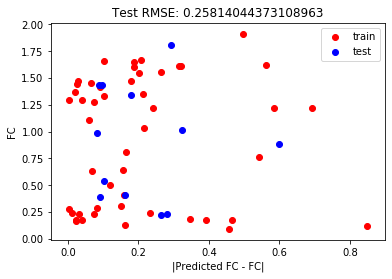

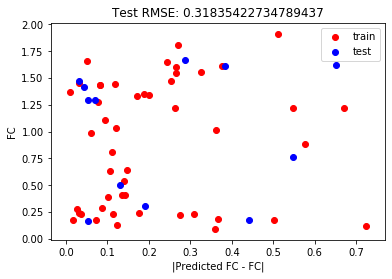

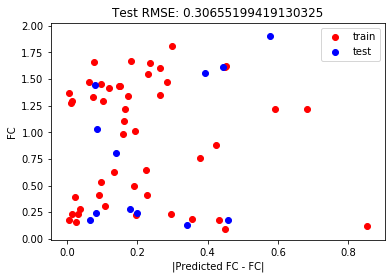

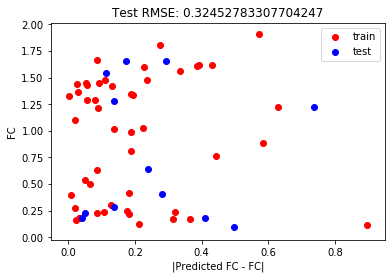

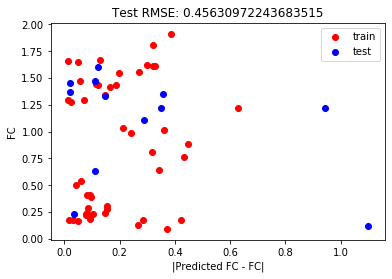

In [6]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression_cv(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.run_model(k = k)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
train RMSE:  [0.27705352 0.24919551 0.25541658 0.25906563 0.25619722]
test RMSE:  [0.28775011 0.46223466 0.41377004 0.36778399 0.36074439]
Train RMSE: 0.26 (+/- 0.02)
Test RMSE: 0.38 (+/- 0.12)


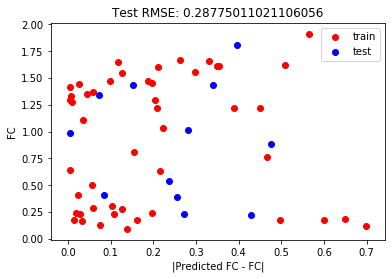

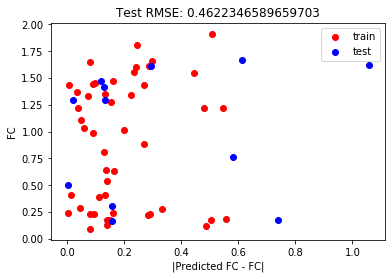

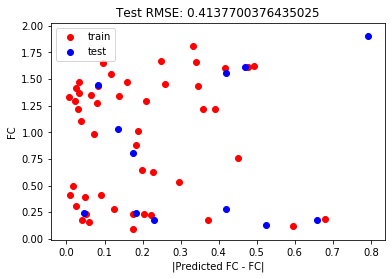

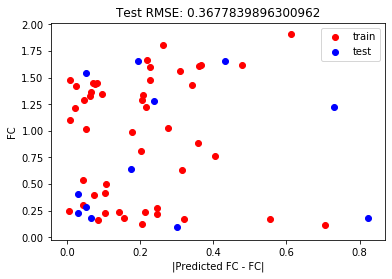

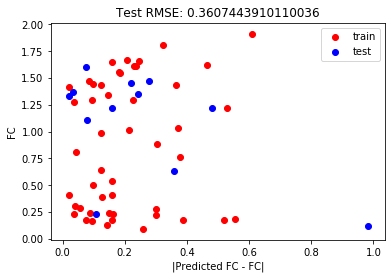

In [7]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression_cv(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.run_model(k = k)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f2e6d010048>,
            kernel_params=None)
train RMSE:  [0.27845033 0.25063915 0.25828627 0.26134492 0.25919916]
test RMSE:  [0.28684508 0.47030366 0.40519173 0.3659846  0.35593104]
Train RMSE: 0.26 (+/- 0.02)
Test RMSE: 0.38 (+/- 0.12)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f2e6d0100d0>,
            kernel_params=None)
train RMSE:  [0.30677021 0.27194816 0.29982542 0.29418008 0.30041715]
test RMSE:  [0.37274496 0.52460865 0.35408327 0.40133476 0.36355841]
Train RMSE: 0.29 (+/- 0.02)
Test RMSE: 0.40 (+/- 0.13)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7f2e6d010158>,
            kernel_params=None)
train RMSE:  [0.24145728 0.2264961  0.2266082  0.22046217 0.20329663]
test RMSE:  [0.27849425 0.37413332 0.38383231 0.36951308 0.4

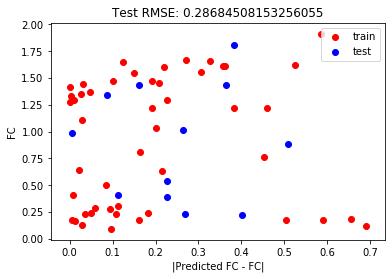

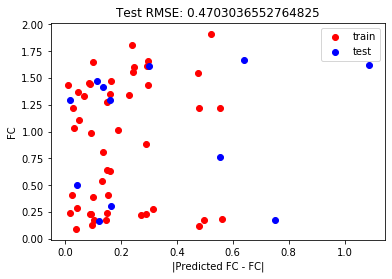

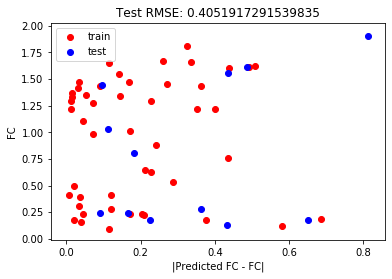

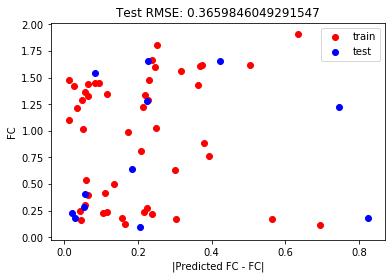

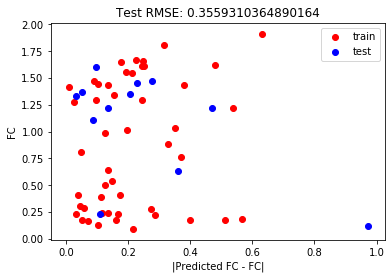

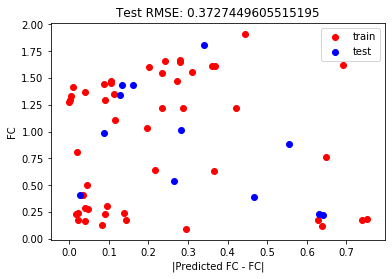

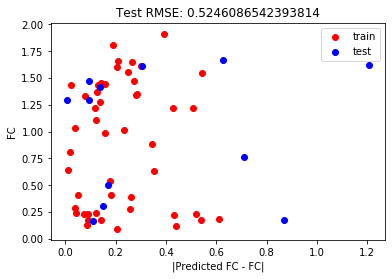

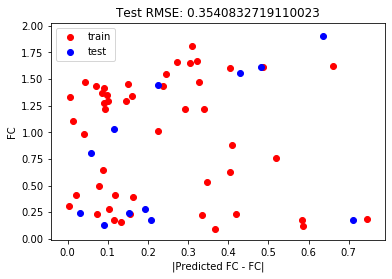

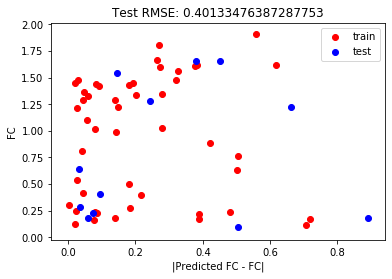

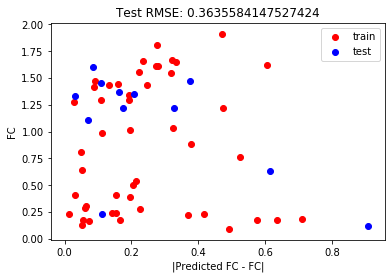

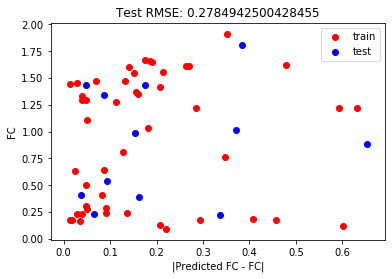

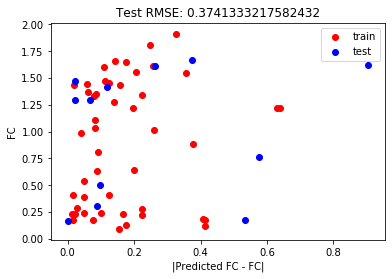

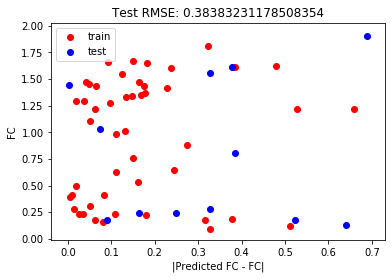

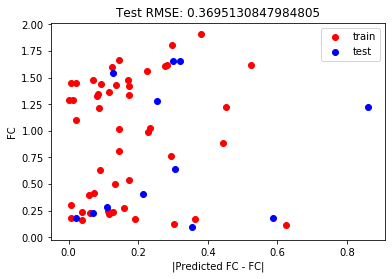

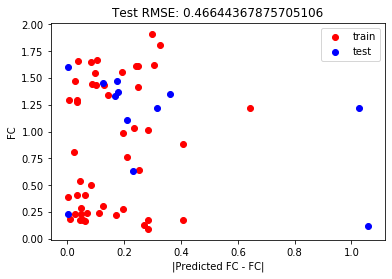

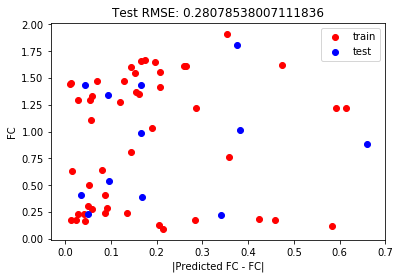

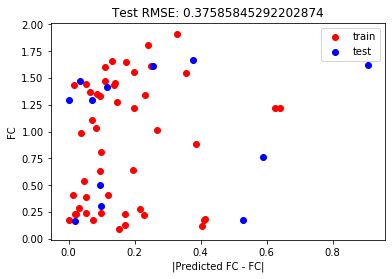

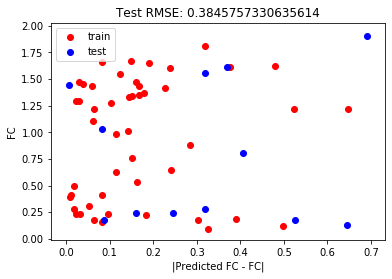

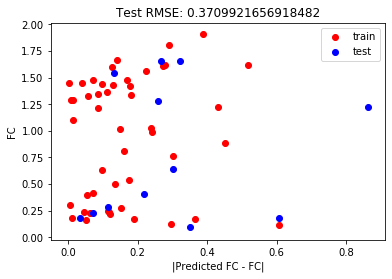

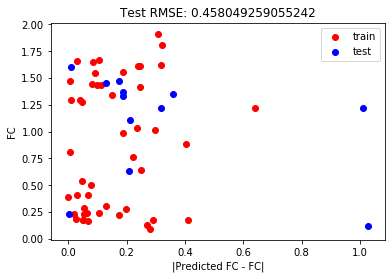

In [8]:
# Show string kernel performance (l = 3)
# label embedding 

for kernel in kernels:
    reg = Regression_cv(KernelRidge(kernel = kernel), data, embedding_method='label')
    reg.run_model(k = k)
    print()

### Gaussian Process Regression

In [ ]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression_cv(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.run_model(k = k)

In [ ]:
# kmer embedding (l = 3)
reg = Regression_cv(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.run_model(k = k)

In [ ]:
# Show string kernel performance (l = 3)
# label embedding 

kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw]

for kernel in kernels:
    reg = Regression_cv(GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel)), data,\
                 embedding_method='label')
    reg.run_model(k = k)
    print()